In [1]:
from dzdy import *

par_script = """ 
PCore pSIR{
    transmission_rate = 1.5
    rec_rate ~ triangle(0.1, 0.2, 0.3)
    beta ~ exp(transmission_rate)
    gamma ~ exp(rec_rate)
    Die ~ exp(0.02)
}
"""

dc_ctbn_script = '''
CTBN SIR_BN{
    life[Alive | Dead]
    sir[S | I | R]
    
    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect(beta) -> Inf 
    Inf -- Recov(gamma) -> Rec
    
    Alive -- Die # from state Alive to transition Die
}
'''

da = DirectorABM()
da.read_pcore(par_script)
da.read_dcore(dc_ctbn_script)
cfd = da.new_abm('ABM_SIR', 'pSIR', 'SIR_BN')
cfd.add_fill_up('Distribution', Name = 'BMI', Distribution = 'norm(23,5)')

cfd.add_network('IDU', 'BA', m=2)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect', net='')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'], 
                      behaviours=['transmission'])


PCore pSIR added
Dcore SIR_BN added


In [2]:
import matplotlib.pyplot as plt

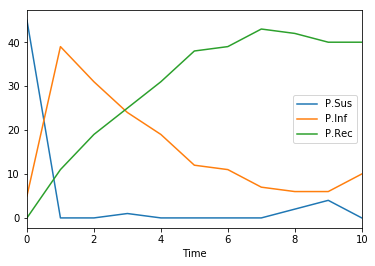

In [3]:
mod_src = da.generate_abm('ABM_SIR')
out_src = simulate(mod_src, y0={'Sus': 45, 'Inf': 5}, fr=0, to=10)
out_src.plot()
plt.show()

Changed transitions: Recov


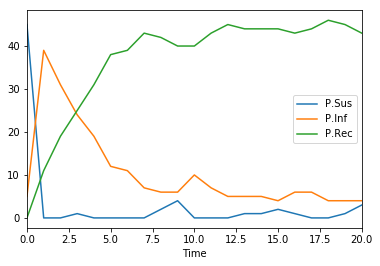

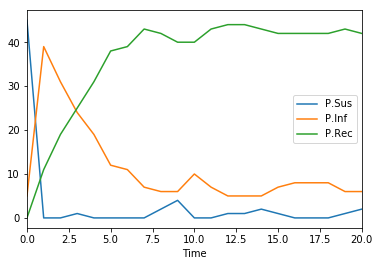

In [4]:
mod_new = da.copy_abm(mod_src)
out_src = update(mod_src, 20)
out_src.plot()
out_new = update(mod_new, 20)
out_new.plot()
plt.show()

In [5]:
mod_src.Meta

Metadata(PC='pSIR', DC='ABM_SIR', Prototype='ABM_SIR')